# Read data

The dataset was compiled from the files for the United States Federal Reserve Bank and the (usa_df.csv) and the European Union Euporean Central Bank (ecb_df.csv) the initial corpus at https://github.com/CarolMoore19/Central-Bank-Texts-Parsed, which contains announcements following all scheduled meetings of monetary policy committees. These data were further cleaned and prepared offline, and combined with macroeconomic variables downloaded from the Fed's public site for economic data, https://fred.stlouisfed.org/.  

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os 

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\Users\dmd8a\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.chdir('/Users/dmd8a/OneDrive - University of Virginia/Desktop/MSDS/DS6050/Project')
df=pd.read_csv('us_ecb_combined_data.csv')

The key variables are:

* Bank:  The US Federal Reserve or European Central Bnak

* rate_curr:  the policy (target) interest rate set at the monetary policy committee meeting.  

* rate_next:  the rate set at the subsequent meeting.

* rate_change:  a categorical variable indicating if the rate changed between the current and next meeting

Macroeconomic variables are only available for the US at this time:

* urate:  the unemployment rate on the first day of the month of the meeting

* pce_inf:  inflation for personal consumption expenditures, less food and energy, on the first day of the month of the meeting.  This is the inflation concept that the Fed uses for policy.

* effective_ffr:  The market federal funds rate on the first day of the month of the meeting.  When setting policy, the fed is trying to influence this interest rate.

Other variables - filename, date_dt, and chron_order_in_country - exist to to keep track of the meeting dates and do not enter into the analysis below.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bank                    434 non-null    object 
 1   filename                434 non-null    object 
 2   date_dt                 434 non-null    object 
 3   chron_order_in_country  434 non-null    int64  
 4   rate_curr               434 non-null    float64
 5   rate_next               434 non-null    float64
 6   rate_change             434 non-null    int64  
 7   urate                   171 non-null    float64
 8   pce_inf                 171 non-null    float64
 9   effective_ffr           171 non-null    float64
 10  statement               434 non-null    object 
dtypes: float64(5), int64(2), object(4)
memory usage: 37.4+ KB


In [4]:
df.shape

(434, 11)

# Standardize continuous variables

To predict the interest rate level to be set at the next policy meeting, we scale the target variables: 'rate_next' , 'rate_curr', and the macroeconomic variables.

Note that the central bank communications are tailored for their own jurisdictions and economic conditions.  The policy interest rate concept differs for each bank. Further, the ranges of experience are differ:  ECB has had negative nominal interest rates, which the Fed never had. 

For this reason, we apply a stratified standardization - one for the ECB and one for the US banks. This means that a standardized value of 0 represents the average rate for the ECB and the Fed, respectively, rather than an overall average across both banks.

In [5]:
df.bank.value_counts()

ecb      265
usfed    169
Name: bank, dtype: int64

In [6]:
#Target var - next meeting policy rate
df['y_std_us'] = np.where(df.bank=='usfed',
                          (df.rate_next - np.mean(df.rate_next))/np.std(df.rate_next),np.nan)
df['y_std_ecb'] = np.where(df.bank=='ecb',
                          (df.rate_next - np.mean(df.rate_next))/np.std(df.rate_next),np.nan)
df['y_std'] = np.where(df.bank=='ecb',df.y_std_ecb,df.y_std_us)

In [7]:
df[['bank','y_std_us','y_std_ecb', 'y_std']]

,bank,y_std_us,y_std_ecb,y_std
0,usfed,0.039051,NaN,0.039051
1,usfed,0.039051,NaN,0.039051
2,usfed,0.039051,NaN,0.039051
3,usfed,-0.271642,NaN,-0.271642
4,usfed,-0.271642,NaN,-0.271642
...,...,...,...,...
429,ecb,NaN,-1.126050,-1.126050
430,ecb,NaN,-1.126050,-1.126050
431,ecb,NaN,-1.126050,-1.126050
432,ecb,NaN,-0.815357,-0.815357


In [8]:
#Current var -  policy rate set at current meeting
df['y_std_us_curr'] = np.where(df.bank=='usfed',
                          (df.rate_curr - np.mean(df.rate_curr))/np.std(df.rate_curr),np.nan)
df['y_std_ecb_curr'] = np.where(df.bank=='ecb',
                          (df.rate_curr - np.mean(df.rate_curr))/np.std(df.rate_curr),np.nan)
df['y_std_curr'] = np.where(df.bank=='ecb',df.y_std_ecb_curr,df.y_std_us_curr)

### Standardize macroeconomic variables - only available for US

In [9]:
#Unemployment rate the first of the month in which the meeting occurred.
df['urate_us_std'] = np.where(df.bank=='usfed',
                          (df.urate - np.mean(df.urate))/np.std(df.urate),np.nan)

#Inflation
df['inf_us_std'] = np.where(df.bank=='usfed',(
    df.pce_inf - np.mean(df.pce_inf))/np.std(df.pce_inf),np.nan)


#Effective (market) Federal Fuinds RATE
df['effr_us_std'] = np.where(df.bank=='usfed',
    (df.effective_ffr - np.mean(df.effective_ffr))/np.std(df.effective_ffr),np.nan)


# Keep the variables we need for the analysis

The rate_change variable includes 3 categories - up, down, and same. After some experimentation and following examples in the literature we chose to model a binary outcome, up (1) or not up (0).

In [10]:
df=df[['statement', 'y_std_curr','y_std','urate_us_std', 'inf_us_std', 'effr_us_std', 'rate_change']]
#df=df[['statement', 'rate_change', 'rate_next']]
#df.head(10)

,statement,y_std_curr,y_std,urate_us_std,inf_us_std,effr_us_std,rate_change
0,the federal open market committee decided toda...,0.037428,0.039051,-0.104017,-0.273528,0.348743,0
1,the federal open market committee decided toda...,0.037428,0.039051,-0.104017,-0.358325,0.309969,0
2,the federal open market committee decided toda...,0.037428,0.039051,-0.153426,-0.238576,0.361668,0
3,the federal open market committee decided toda...,0.037428,-0.271642,-0.153426,0.706411,0.387517,-1
4,the federal open market committee decided toda...,-0.273162,-0.271642,-0.054609,-0.225833,-0.013152,0
5,the federal open market committee decided toda...,-0.273162,-0.271642,-0.005201,-0.136049,-0.058388,0
6,the federal open market committee decided toda...,-0.273162,-0.271642,-0.104017,-0.122053,0.051472,0
7,the federal open market committee decided toda...,-0.273162,-0.271642,-0.054609,-0.136619,0.083784,0
8,the federal open market committee decided to k...,-0.273162,-0.426989,0.044207,-0.310871,0.019160,-1
9,the federal open market committee decided toda...,-0.428457,-0.426989,0.143024,-0.441503,0.129021,0


In [13]:
#df.head(20)

In [12]:
df['rate_change'] = np.where(df['rate_change'] == 1, 0, df['rate_change'])
df['rate_change'] = np.where(df['rate_change'] == -1, 1, df['rate_change']) # now down is 1 and not down is 0
#df.head(20)

,statement,y_std_curr,y_std,urate_us_std,inf_us_std,effr_us_std,rate_change
0,the federal open market committee decided toda...,0.037428,0.039051,-0.104017,-0.273528,0.348743,0
1,the federal open market committee decided toda...,0.037428,0.039051,-0.104017,-0.358325,0.309969,0
2,the federal open market committee decided toda...,0.037428,0.039051,-0.153426,-0.238576,0.361668,0
3,the federal open market committee decided toda...,0.037428,-0.271642,-0.153426,0.706411,0.387517,1
4,the federal open market committee decided toda...,-0.273162,-0.271642,-0.054609,-0.225833,-0.013152,0
5,the federal open market committee decided toda...,-0.273162,-0.271642,-0.005201,-0.136049,-0.058388,0
6,the federal open market committee decided toda...,-0.273162,-0.271642,-0.104017,-0.122053,0.051472,0
7,the federal open market committee decided toda...,-0.273162,-0.271642,-0.054609,-0.136619,0.083784,0
8,the federal open market committee decided to k...,-0.273162,-0.426989,0.044207,-0.310871,0.019160,1
9,the federal open market committee decided toda...,-0.428457,-0.426989,0.143024,-0.441503,0.129021,0


# Get some rough stats on the text. Knowng the length of each statement will guide our choice of dimensions later.  

The max approximate length of the statements is 1,011.

In [14]:
approx_length = df['statement'].str.split().str.len()
approx_length.describe()

count     434.000000
mean      229.396313
std       213.255292
min        36.000000
25%        63.000000
50%       148.000000
75%       380.500000
max      1011.000000
Name: statement, dtype: float64

# Shuffle the data and split it into test, train and validation sets.

Although the original data are time-series, the file is not organized as such.  The future values are on the same row as the current values. Therefore we shuffle the data.

We first divide the file into test and train.  Then we split the test file into test and validate (60%, 20%, 20%)

In [15]:
df_shuffled=df.sample(frac=1, random_state=42).reset_index()


In [16]:
df_shuffled.head()

,index,statement,y_std_curr,y_std,urate_us_std,inf_us_std,effr_us_std,rate_change
0,280,"at today's meeting, the governing council of t...",1.279790,1.281827,NaN,NaN,NaN,0
1,78,information received since the federal open ma...,-0.894343,-0.893030,1.477048,-0.047189,-0.756328,0
2,113,information received since the federal open ma...,-0.739048,-0.737683,-0.499284,-0.946329,-0.678779,0
3,253,at today's meeting the governing council of th...,0.192724,0.194398,NaN,NaN,NaN,0
4,324,at today's meeting the governing council of th...,-0.428457,-0.426989,NaN,NaN,NaN,0


In [17]:
df_shuffled.shape

(434, 8)

In [18]:
train_cut=int(.6*df_shuffled.shape[0])
val_cut=int(.8*df_shuffled.shape[0])
print(train_cut, val_cut)

260 347


In [19]:
df_train=df_shuffled.iloc[0:train_cut,:]
df_train

,index,statement,y_std_curr,y_std,urate_us_std,inf_us_std,effr_us_std,rate_change
0,280,"at today's meeting, the governing council of t...",1.279790,1.281827,NaN,NaN,NaN,0
1,78,information received since the federal open ma...,-0.894343,-0.893030,1.477048,-0.047189,-0.756328,0
2,113,information received since the federal open ma...,-0.739048,-0.737683,-0.499284,-0.946329,-0.678779,0
3,253,at today's meeting the governing council of th...,0.192724,0.194398,NaN,NaN,NaN,0
4,324,at today's meeting the governing council of th...,-0.428457,-0.426989,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
255,179,at today's meeting (which was held in the form...,1.279790,1.592521,NaN,NaN,NaN,0
256,320,at today's meeting the governing council of th...,-0.428457,-0.426989,NaN,NaN,NaN,0
257,294,at today's meeting the governing council of th...,1.435086,1.592521,NaN,NaN,NaN,0
258,285,"at today's meeting, the governing council of t...",1.435086,1.437174,NaN,NaN,NaN,0


In [20]:
df_val=df_shuffled.iloc[train_cut:val_cut,:]
df_val       

,index,statement,y_std_curr,y_std,urate_us_std,inf_us_std,effr_us_std,rate_change
260,407,at today's meeting the governing council of th...,-1.096227,-1.094981,NaN,NaN,NaN,0
261,233,at today's meeting the governing council of th...,0.503314,0.194398,NaN,NaN,NaN,1
262,354,"at today's meeting, which was held in bratisla...",-0.739048,-0.737683,NaN,NaN,NaN,0
263,164,the federal reserve is committed to using its ...,-0.894343,-0.893030,-1.042775,4.007804,-0.762790,0
264,136,information received since the federal open ma...,0.348019,0.349745,-1.141592,0.269350,0.600777,0
...,...,...,...,...,...,...,...,...
342,352,at today's meeting the governing council of th...,-0.583753,-0.582336,NaN,NaN,NaN,0
343,216,at today's meeting the governing council of th...,0.969200,0.971133,NaN,NaN,NaN,0
344,279,at today's meeting the governing council of th...,1.279790,1.281827,NaN,NaN,NaN,0
345,377,at today's meeting the governing council of th...,-1.018579,-1.017308,NaN,NaN,NaN,0


In [21]:
df_test=df_shuffled.iloc[val_cut:df_shuffled.shape[0],:]
df_test  

,index,statement,y_std_curr,y_std,urate_us_std,inf_us_std,effr_us_std,rate_change
347,236,at today's meeting the governing council of th...,0.192724,0.194398,NaN,NaN,NaN,0
348,207,at today's meeting the governing council of th...,1.745676,1.747868,NaN,NaN,NaN,0
349,212,at today's meeting the governing council of th...,1.279790,1.281827,NaN,NaN,NaN,0
350,295,at today's meeting the governing council of th...,1.590381,1.592521,NaN,NaN,NaN,0
351,397,at today's meeting the governing council of th...,-1.096227,-1.094981,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
429,71,information received since the federal open ma...,-0.894343,-0.893030,1.724089,-0.732240,-0.711091,0
430,106,information received since the federal open ma...,-0.894343,-0.893030,-0.153426,-0.657313,-0.769253,0
431,270,"at today's meeting, which was held in madrid, ...",0.658609,0.660439,NaN,NaN,NaN,0
432,348,at today's meeting the governing council of th...,-0.583753,-0.582336,NaN,NaN,NaN,0


# Part I.  Model with embeddings derived from our corpus.  

In this model, our own corpus is the source of the embedding layer.  By using our own embeddings we may be making training less efficient and generalizable than if we used a pre-trained model.  Given the small size of our data set, however, training is still very fast and because of the highly specialized nature of our corpus, self-created embeddings could be more predictive.  

The next section of code was demonstrated by Sucky in:
https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f. It offers a straightforward way to create embeddings in Keras and incorporate them into a neural network.

The first step is to ensure that the data are in the correct format:  the statement should be a string and the target variables, y_std_curr and y_std should be floats.

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 347 to 433
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         87 non-null     int64  
 1   statement     87 non-null     object 
 2   y_std_curr    87 non-null     float64
 3   y_std         87 non-null     float64
 4   urate_us_std  30 non-null     float64
 5   inf_us_std    30 non-null     float64
 6   effr_us_std   30 non-null     float64
 7   rate_change   87 non-null     int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 5.6+ KB


In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         260 non-null    int64  
 1   statement     260 non-null    object 
 2   y_std_curr    260 non-null    float64
 3   y_std         260 non-null    float64
 4   urate_us_std  104 non-null    float64
 5   inf_us_std    104 non-null    float64
 6   effr_us_std   104 non-null    float64
 7   rate_change   260 non-null    int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 16.4+ KB


In [24]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 260 to 346
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         87 non-null     int64  
 1   statement     87 non-null     object 
 2   y_std_curr    87 non-null     float64
 3   y_std         87 non-null     float64
 4   urate_us_std  35 non-null     float64
 5   inf_us_std    35 non-null     float64
 6   effr_us_std   35 non-null     float64
 7   rate_change   87 non-null     int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 5.6+ KB


# Interest rate level prediction - predicting policy at next meeting

In the next section we try to predict the value of the interest rate using various models.

In [25]:
train_statement = df_train.statement
train_label = df_train.rate_change
#train_label=df_train.rate_next

test_statement = df_test.statement
test_label = df_test.rate_change
#test_label = df_test.rate_next

val_statement = df_val.statement
#val_label = df_val.rate_next
val_label = df_val.rate_change

training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
val_sentences = []
val_labels = []

for row in train_statement:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)

for row in test_statement:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

for row in val_statement:
    val_sentences.append(str(row))
for row in val_label:
    val_labels.append(row)

In [26]:
#print(val_sentences[0:2])

In [27]:
#print(val_labels)

In [28]:
#Convert labels from lists to numpy arrays.  We deal with the statements below.
training_labels_final = np.array(training_labels)
val_labels_final = np.array(val_labels)
test_labels_final = np.array(testing_labels)

In [29]:
#print(val_labels_final)

# Embedding based on the corpus

We first examine embeddings based on the corpus.  

* The embedding will look at the first 1200 words in each statement. Since the maximum length in our dataset is only about 1,000 words, this is not binding.  However, we choose a larger value to accomodate potentially longer statements in the future.

* There is no need to truncate statements in the current file, but to accomodate future data we set the tokenizer to truncate words at the end of each statement.

* To ensure the embeddings are all the same length, statements padded with zeros to make them all 1500 in length.

* We choose a vocab_size for the corpus

* The 'OOV' token represents words that occur with low frequency and are not part of the vocabulary.

* An embedding dimension of 16 means that the embedding will be a matrix of 1500 (number of tokens) by 16 (size of the vector for each token).  These vectors can be thought of as the 'features' for each token, and help the model understand the similarity between tokens and statements.

In [30]:
max_length = 1200 #Number of tokens per statement
trunc_type = 'post'
padding_type = 'post'

vocab_size = 5000 #choose 5000 words to constitute vocabulary
oov_tok = '<OOV>' #indicate out of vocabularly words

embedding_dim = 16 #number of features per word in vocabulary

We next tokenize the text and develop the vocabulary, which given by word_index

In [31]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [32]:
#Find the indexes for select words from the word index
test_list=['<OOV>','inflationary','war','macroeconomic','euro','debt','current','voting','projections']
[word_index[i] for i in test_list]

[1, 855, 1718, 1155, 329, 247, 179, 182, 828]

In [33]:
len(word_index)

1923

Assure that the arrays fed into the neural network are all the same length.

In [34]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

Let's take a look at these sequences arrays.

In [35]:
print(padded.shape, val_padded.shape, test_padded.shape)

(260, 1200) (87, 1200) (87, 1200)


In [36]:
padded

array([[  0,   0,   0, ..., 134, 829,  77],
       [  0,   0,   0, ...,  91, 202, 145],
       [  0,   0,   0, ..., 120,  54,  24],
       ...,
       [  0,   0,   0, ...,  72, 133, 134],
       [  0,   0,   0, ..., 134, 829,  77],
       [  0,   0,   0, ...,  72, 217,  77]])

# Model A

This model was demonstrated by Sucky in a blog post.  The 1D Global Average Pooling layer simply flattens the embedding layer to be a vector.  (We found that the model did much worse without this layer). Each element of the vector is connected to a 6-node dense layer.  The relu was chosen as an activation function due to its ability to mitigate the vanishing gradient problem.  A linear activation was chosen in the final layer because the target is a continuous variable that can take positive or negative values. 

In [37]:

modela = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
modela.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [39]:
modela.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 16)          80000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 80,109
Trainable params: 80,109
Non-trainable params: 0
_________________________________________________________________


In [40]:
num_epochs = 300 #chosen after trial and error
history = modela.fit(padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(val_padded, val_labels_final))

Epoch 1/300
9/9 [==============================] - 1s 32ms/step - loss: 0.6873 - precision: 0.0000e+00 - val_loss: 0.6807 - val_precision: 0.0000e+00
Epoch 2/300
9/9 [==============================] - 0s 6ms/step - loss: 0.6732 - precision: 0.0000e+00 - val_loss: 0.6616 - val_precision: 0.0000e+00
Epoch 3/300
9/9 [==============================] - 0s 6ms/step - loss: 0.6528 - precision: 0.0000e+00 - val_loss: 0.6399 - val_precision: 0.0000e+00
Epoch 4/300
9/9 [==============================] - 0s 6ms/step - loss: 0.6300 - precision: 0.0000e+00 - val_loss: 0.6167 - val_precision: 0.0000e+00
Epoch 5/300
9/9 [==============================] - 0s 6ms/step - loss: 0.6062 - precision: 0.0000e+00 - val_loss: 0.5924 - val_precision: 0.0000e+00
Epoch 6/300
9/9 [==============================] - 0s 6ms/step - loss: 0.5815 - precision: 0.0000e+00 - val_loss: 0.5675 - val_precision: 0.0000e+00
Epoch 7/300
9/9 [==============================] - 0s 6ms/step - loss: 0.5551 - precision: 0.0000e+00 - v

<Figure size 432x288 with 0 Axes>

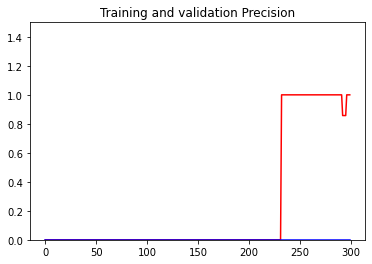

<Figure size 432x288 with 0 Axes>

In [41]:

precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [42]:
modela.evaluate(test_padded, test_labels_final)

3/3 [==============================] - 0s 2ms/step - loss: 0.3244 - precision: 1.0000


[0.32443565130233765, 1.0]


# Model B experiment with a 1-D convolution layer.  

The length of the convolutional window is 3, meaning that the convolutional filter will examine small chunks of 3 elements in the vectorized texts. We specify 16 filters, each filter can identify different features of the text. We chose these hyperparams by trial and error. 

Overall, the performance of the 1D Convolutional layer is very sensitive to the number of filters and kernels.  The RMSE for Model B is .53 compared to .33 for Model A after 300 epochs (not shown).  Increasing training time to 500 epochs resulted in an RMSE of .51 in the test set, although validation performance improved a lot.

In [43]:
#This model has a convolutional layer
modelb = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [44]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
modelb.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [45]:
modelb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 16)          80000     
                                                                 
 conv1d (Conv1D)             (None, 1198, 16)          784       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 80,893
Trainable params: 80,893
Non-trainable params: 0
____________________________________________________

In [46]:
num_epochs = 500
history = modelb.fit(padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(val_padded, val_labels_final))

Epoch 1/500
9/9 [==============================] - 1s 34ms/step - loss: 0.6827 - precision: 0.0000e+00 - val_loss: 0.6712 - val_precision: 0.0000e+00
Epoch 2/500
9/9 [==============================] - 0s 11ms/step - loss: 0.6631 - precision: 0.0000e+00 - val_loss: 0.6503 - val_precision: 0.0000e+00
Epoch 3/500
9/9 [==============================] - 0s 10ms/step - loss: 0.6404 - precision: 0.0000e+00 - val_loss: 0.6245 - val_precision: 0.0000e+00
Epoch 4/500
9/9 [==============================] - 0s 10ms/step - loss: 0.6115 - precision: 0.0000e+00 - val_loss: 0.5915 - val_precision: 0.0000e+00
Epoch 5/500
9/9 [==============================] - 0s 10ms/step - loss: 0.5748 - precision: 0.0000e+00 - val_loss: 0.5502 - val_precision: 0.0000e+00
Epoch 6/500
9/9 [==============================] - 0s 10ms/step - loss: 0.5304 - precision: 0.0000e+00 - val_loss: 0.5015 - val_precision: 0.0000e+00
Epoch 7/500
9/9 [==============================] - 0s 9ms/step - loss: 0.4761 - precision: 0.0000e+0

<Figure size 432x288 with 0 Axes>

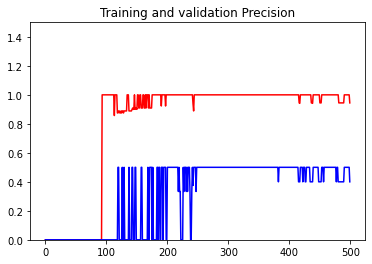

<Figure size 432x288 with 0 Axes>

In [47]:

precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [48]:
modelb.evaluate(test_padded, test_labels_final)

3/3 [==============================] - 0s 3ms/step - loss: 0.5189 - precision: 0.8000


[0.5189329385757446, 0.800000011920929]

# Part II. Pre-trained embedding specialized for Central Banks


### First we apply the central bank-specific embeddings by Zahner and Baumgaertner predicting the next rate.  We will first explore the embeddings then run the models.  We find there are over 72,000 word vectors and 300 features per word.  

In [49]:
zb = pd.read_csv('word_embeddings_3b.csv') #, header=1

In [50]:
zb.shape

(73082, 301)

In [51]:
zb.head()

,word,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300
0,</s>,0.080156,0.088501,-0.076703,-0.065645,0.027367,0.060499,0.018841,0.004232,-0.072163,...,-0.025759,0.030279,0.019642,-0.030535,0.058834,-0.092278,-0.028259,-0.026270,-0.033166,0.061495
1,the,-0.038091,-0.049348,-0.028680,-0.018713,0.063518,0.057007,0.021474,0.084622,-0.108604,...,0.004401,0.030320,0.001037,-0.081768,0.011895,0.025118,0.029903,0.029950,0.002812,-0.065045
2,NaN,-0.061148,-0.000166,-0.058344,0.014657,0.039084,0.056894,-0.048181,0.049727,-0.075358,...,-0.038889,0.069039,0.018876,-0.050831,0.029056,0.018375,0.052614,0.057787,-0.000694,-0.043442
3,.,-0.099335,0.001326,-0.048134,-0.010280,-0.000963,0.022920,-0.026348,0.010025,-0.068051,...,-0.032482,0.063615,-0.020517,-0.017632,0.029572,0.061214,0.075277,0.135811,-0.011819,-0.106832
4,of,-0.092714,0.016854,-0.048257,0.010404,0.047617,0.060156,-0.019659,0.040367,-0.107395,...,-0.036493,0.109343,-0.000342,-0.072286,0.045893,0.002628,0.056748,0.037754,-0.022448,-0.029516


In [52]:
zb=zb.set_index('word')

In [53]:
zb_transposed = zb.T

In [54]:
zb_transposed.head()

word,</s>,the,NaN,.,of,to,and,in,[decimal],a,...,cop25,alistair,effectuation,fhfas,vaciago,just-i,ancona,1999–2001,ctos,altcoins
V1,0.080156,-0.038091,-0.061148,-0.099335,-0.092714,0.019735,-0.015383,0.009759,-0.047645,0.060641,...,-0.078843,-0.023943,0.021798,0.034371,-0.039774,0.003213,-0.061320,-0.033173,-0.207396,0.019181
V2,0.088501,-0.049348,-0.000166,0.001326,0.016854,0.017912,0.014828,-0.050921,-0.077989,-0.000283,...,-0.026619,-0.013862,0.074990,-0.068248,0.046751,0.017442,-0.031018,-0.095737,0.106908,0.013239
V3,-0.076703,-0.028680,-0.058344,-0.048134,-0.048257,-0.018683,-0.044502,-0.004150,0.003544,-0.009209,...,0.120499,0.074515,0.022469,-0.012830,0.029337,-0.059405,0.003367,0.104349,0.015193,-0.034064
V4,-0.065645,-0.018713,0.014657,-0.010280,0.010404,-0.022496,-0.005357,-0.009244,0.034186,-0.019526,...,0.041775,-0.004044,0.053189,-0.057841,0.028182,-0.011910,0.006949,-0.006095,-0.042527,0.041970
V5,0.027367,0.063518,0.039084,-0.000963,0.047617,0.073557,0.016352,0.076654,0.046362,0.011457,...,0.062888,-0.030928,0.072676,-0.003460,0.053458,0.047244,0.068072,0.091003,0.006158,-0.034872


In [55]:
list_of_columns = zb.values.tolist() # was df_original

In [56]:
words=list(zb_transposed.columns.values)

In [57]:
zb.head() #df_original

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300
word,,,,,,,,,,,,,,,,,,,,,
</s>,0.080156,0.088501,-0.076703,-0.065645,0.027367,0.060499,0.018841,0.004232,-0.072163,0.044426,...,-0.025759,0.030279,0.019642,-0.030535,0.058834,-0.092278,-0.028259,-0.026270,-0.033166,0.061495
the,-0.038091,-0.049348,-0.028680,-0.018713,0.063518,0.057007,0.021474,0.084622,-0.108604,-0.092650,...,0.004401,0.030320,0.001037,-0.081768,0.011895,0.025118,0.029903,0.029950,0.002812,-0.065045
NaN,-0.061148,-0.000166,-0.058344,0.014657,0.039084,0.056894,-0.048181,0.049727,-0.075358,-0.038712,...,-0.038889,0.069039,0.018876,-0.050831,0.029056,0.018375,0.052614,0.057787,-0.000694,-0.043442
.,-0.099335,0.001326,-0.048134,-0.010280,-0.000963,0.022920,-0.026348,0.010025,-0.068051,-0.049312,...,-0.032482,0.063615,-0.020517,-0.017632,0.029572,0.061214,0.075277,0.135811,-0.011819,-0.106832
of,-0.092714,0.016854,-0.048257,0.010404,0.047617,0.060156,-0.019659,0.040367,-0.107395,-0.068698,...,-0.036493,0.109343,-0.000342,-0.072286,0.045893,0.002628,0.056748,0.037754,-0.022448,-0.029516


In [58]:
words[65]

'inflation'

In [59]:
embeddings_index = {} 

for i in range(len(words)):
    embeddings_index[words[i]]=list_of_columns[i]
    

#word_column = df['word']

print("Found %s word vectors." % len(embeddings_index))

Found 72096 word vectors.


# Prepare pretrained embeddings for the model and see how many words in our vocabulary are in the pre-trained model.

Source:  https://keras.io/examples/nlp/pretrained_word_embeddings/

In [60]:
#vocab_size=2000
num_tokens = len(range(vocab_size)) + 2
embedding_dim = 300 #number of features per word in pre-trained model
hits = 0 
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        #print(word, end ="")
        #print(word)
#print("Converted %d words (%d misses)" % (hits, misses))


In [61]:
print(embedding_matrix.shape[1])

300


In [62]:
from tensorflow import keras 
from tensorflow.keras.layers import Embedding

modela_zb = tf.keras.Sequential([
    tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length = max_length, trainable=False),
    #tf.keras.layers.Embedding(vocab_size+2,embedding_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),input_length=max_length, trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) # the two embedding statements here do exactly the same thing

In [63]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
modela_zb.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [64]:
modela_zb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 300)         1500600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 1806      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,502,413
Trainable params: 1,813
Non-trainable params: 1,500,600
_________________________________________________________________


In [65]:
num_epochs = 300
history = modela_zb.fit(padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(val_padded, val_labels_final))

Epoch 1/300
9/9 [==============================] - 1s 65ms/step - loss: 0.6807 - precision: 0.0000e+00 - val_loss: 0.6742 - val_precision: 0.0000e+00
Epoch 2/300
9/9 [==============================] - 0s 31ms/step - loss: 0.6648 - precision: 0.0000e+00 - val_loss: 0.6600 - val_precision: 0.0000e+00
Epoch 3/300
9/9 [==============================] - 0s 30ms/step - loss: 0.6492 - precision: 0.0000e+00 - val_loss: 0.6458 - val_precision: 0.0000e+00
Epoch 4/300
9/9 [==============================] - 0s 33ms/step - loss: 0.6332 - precision: 0.0000e+00 - val_loss: 0.6318 - val_precision: 0.0000e+00
Epoch 5/300
9/9 [==============================] - 0s 35ms/step - loss: 0.6177 - precision: 0.0000e+00 - val_loss: 0.6181 - val_precision: 0.0000e+00
Epoch 6/300
9/9 [==============================] - 0s 27ms/step - loss: 0.6028 - precision: 0.0000e+00 - val_loss: 0.6045 - val_precision: 0.0000e+00
Epoch 7/300
9/9 [==============================] - 0s 28ms/step - loss: 0.5878 - precision: 0.0000e+

<Figure size 432x288 with 0 Axes>

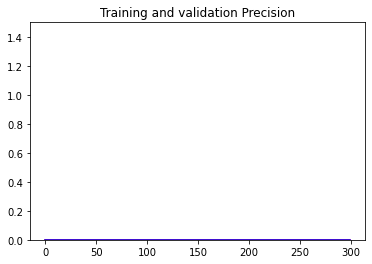

<Figure size 432x288 with 0 Axes>

In [66]:

precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [67]:
modela_zb.evaluate(test_padded, test_labels_final)

3/3 [==============================] - 0s 17ms/step - loss: 0.3808 - precision: 0.0000e+00


[0.38075533509254456, 0.0]

### Model B with the Z&B embeddings

Adds a conv layer

In [68]:

modelb_zb = tf.keras.Sequential([
    tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length = max_length, trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [69]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
modelb_zb.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [70]:
modelb_zb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 300)         1500600   
                                                                 
 conv1d (Conv1D)             (None, 1196, 128)         192128    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,693,509
Trainable params: 192,909
Non-trainable params: 1,500,600
________________________________________

In [71]:
num_epochs = 100 
history = modelb_zb.fit(padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(val_padded, val_labels_final))

Epoch 1/100
9/9 [==============================] - 2s 212ms/step - loss: 0.6439 - precision: 0.0000e+00 - val_loss: 0.5931 - val_precision: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 2s 187ms/step - loss: 0.5269 - precision: 0.0000e+00 - val_loss: 0.4964 - val_precision: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 2s 214ms/step - loss: 0.4305 - precision: 0.0000e+00 - val_loss: 0.4243 - val_precision: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 2s 250ms/step - loss: 0.3668 - precision: 0.0000e+00 - val_loss: 0.3811 - val_precision: 0.0000e+00
Epoch 5/100
9/9 [==============================] - 2s 218ms/step - loss: 0.3382 - precision: 0.0000e+00 - val_loss: 0.3579 - val_precision: 0.0000e+00
Epoch 6/100
9/9 [==============================] - 2s 178ms/step - loss: 0.3244 - precision: 0.0000e+00 - val_loss: 0.3483 - val_precision: 0.0000e+00
Epoch 7/100
9/9 [==============================] - 2s 190ms/step - loss: 0.3181 - precision: 0

<Figure size 432x288 with 0 Axes>

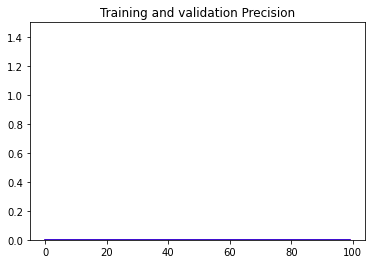

<Figure size 432x288 with 0 Axes>

In [72]:

precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [73]:
modelb_zb.evaluate(test_padded, test_labels_final)

3/3 [==============================] - 0s 57ms/step - loss: 0.3720 - precision: 0.0000e+00


[0.3719780445098877, 0.0]

# Part III.  GloVE Embeddings

After downloading Glove, we adapt our code to use it.  GloVE contains 400,000 tokens and comes with a variety of embedding dims.  We chose the smallest - 50 features per token.

All but 45 words in our vocab were in GloVE.  The "misses" tended to be words with apostrophes, abbrevaitions and compound words (later we will clean our data to better match the pre-trained embeddings).

In [74]:
#file = pd.read_table('glove.6B.50d.txt') # okay this one may be too big - using 50 from now on

In [75]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [76]:
embeddings_index = {}
with open('glove.6B.50d.txt', encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [77]:
num_tokens = len(range(vocab_size)) + 2 #vocab size was specified in Part I
embedding_dim = 50 #we chose the 50-dim embedding of GloVE
hits = 0
misses = 0

# Prepare embedding matrix. This matrix matches OUR vocabulary to the ELEMENTS in GloVE.
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        #print(word, end ="")
        print(word)
print("Converted %d words (%d misses)" % (hits, misses))

<OOV>
today's
committee's
pepp
tltro
council's
href
reserve's
covid
pressconf
eurosystem's
ecb's
regardingnon
banks’
peltros
eurep
households'
bankofengland
federalreserve
optionality
ltros
tltros
counterparties’
10basis
december2015
4percent
overbidding
2818
is000608
tomaintain
 
is010830
is000302
is001214
is010201
russia's
board's
summer's
is020606
actionsthe
banksinformation
is010510
is000706
peltro
4½
Converted 1878 words (45 misses)


In [78]:

modela_glove = tf.keras.Sequential([
    tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length = max_length, trainable=False),  
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [79]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
modela_glove.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [80]:
modela_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 50)          250100    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 250,413
Trainable params: 313
Non-trainable params: 250,100
_________________________________________________________________


In [81]:
num_epochs = 300
history = modela_glove.fit(padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(val_padded, val_labels_final))

Epoch 1/300
9/9 [==============================] - 1s 28ms/step - loss: 0.7109 - precision: 0.1061 - val_loss: 0.6929 - val_precision: 0.0741
Epoch 2/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6822 - precision: 0.0444 - val_loss: 0.6691 - val_precision: 0.0000e+00
Epoch 3/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6564 - precision: 0.0000e+00 - val_loss: 0.6477 - val_precision: 0.0000e+00
Epoch 4/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6324 - precision: 0.0000e+00 - val_loss: 0.6286 - val_precision: 0.0000e+00
Epoch 5/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6113 - precision: 0.0000e+00 - val_loss: 0.6111 - val_precision: 0.0000e+00
Epoch 6/300
9/9 [==============================] - 0s 6ms/step - loss: 0.5921 - precision: 0.0000e+00 - val_loss: 0.5945 - val_precision: 0.0000e+00
Epoch 7/300
9/9 [==============================] - 0s 5ms/step - loss: 0.5734 - precision: 0.0000e+00 - val_loss: 0.5

<Figure size 432x288 with 0 Axes>

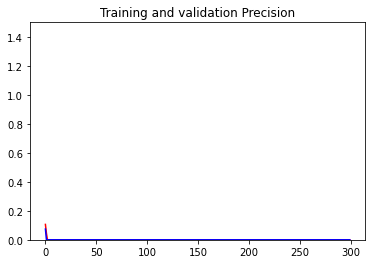

<Figure size 432x288 with 0 Axes>

In [82]:

precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [83]:
modela_glove.evaluate(test_padded, test_labels_final)

3/3 [==============================] - 0s 3ms/step - loss: 0.3771 - precision: 0.0000e+00


[0.3771357834339142, 0.0]

### Model B with GloVe 50

In [84]:
modelb_glove50 = tf.keras.Sequential([
    tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length = max_length, trainable=False),  
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [85]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
modelb_glove50.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [86]:
modelb_glove50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 50)          250100    
                                                                 
 conv1d (Conv1D)             (None, 1196, 128)         32128     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 283,009
Trainable params: 32,909
Non-trainable params: 250,100
_____________________________________________

In [87]:
num_epochs = 300
history = modelb_glove50.fit(padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(val_padded, val_labels_final))

Epoch 1/300
9/9 [==============================] - 1s 82ms/step - loss: 0.6074 - precision: 0.0000e+00 - val_loss: 0.5457 - val_precision: 0.0000e+00
Epoch 2/300
9/9 [==============================] - 1s 63ms/step - loss: 0.4685 - precision: 0.0000e+00 - val_loss: 0.4457 - val_precision: 0.0000e+00
Epoch 3/300
9/9 [==============================] - 1s 70ms/step - loss: 0.3807 - precision: 0.0000e+00 - val_loss: 0.3870 - val_precision: 0.0000e+00
Epoch 4/300
9/9 [==============================] - 1s 68ms/step - loss: 0.3362 - precision: 0.0000e+00 - val_loss: 0.3601 - val_precision: 0.0000e+00
Epoch 5/300
9/9 [==============================] - 1s 68ms/step - loss: 0.3244 - precision: 0.0000e+00 - val_loss: 0.3487 - val_precision: 0.0000e+00
Epoch 6/300
9/9 [==============================] - 1s 63ms/step - loss: 0.3179 - precision: 0.0000e+00 - val_loss: 0.3435 - val_precision: 0.0000e+00
Epoch 7/300
9/9 [==============================] - 1s 66ms/step - loss: 0.3134 - precision: 0.0000e+

<Figure size 432x288 with 0 Axes>

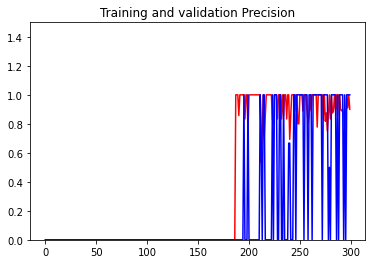

<Figure size 432x288 with 0 Axes>

In [88]:

precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [89]:
modelb_glove50.evaluate(test_padded, test_labels_final)

3/3 [==============================] - 0s 17ms/step - loss: 0.4008 - precision: 1.0000


[0.4008418023586273, 1.0]

### Model A with bigger GloVe set predicting next interest rate

In [90]:
embeddings_index = {}
with open('glove.6B.200d.txt', encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [91]:
num_tokens = len(range(vocab_size)) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        #print(word, end ="")
        #print(word)
#print("Converted %d words (%d misses)" % (hits, misses))

In [92]:
modela_glove_next_rate = tf.keras.Sequential([
    tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix], input_length = max_length, trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [93]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
modela_glove_next_rate.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [94]:
modela_glove_next_rate.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 200)         1000400   
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,001,613
Trainable params: 1,213
Non-trainable params: 1,000,400
_________________________________________________________________


In [95]:
num_epochs = 300
history = modela_glove_next_rate.fit(padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(val_padded, val_labels_final))

Epoch 1/300
9/9 [==============================] - 1s 44ms/step - loss: 0.6476 - precision: 0.5000 - val_loss: 0.6311 - val_precision: 0.0000e+00
Epoch 2/300
9/9 [==============================] - 0s 21ms/step - loss: 0.6012 - precision: 0.0000e+00 - val_loss: 0.5965 - val_precision: 0.0000e+00
Epoch 3/300
9/9 [==============================] - 0s 24ms/step - loss: 0.5658 - precision: 0.0000e+00 - val_loss: 0.5692 - val_precision: 0.0000e+00
Epoch 4/300
9/9 [==============================] - 0s 20ms/step - loss: 0.5353 - precision: 0.0000e+00 - val_loss: 0.5446 - val_precision: 0.0000e+00
Epoch 5/300
9/9 [==============================] - 0s 20ms/step - loss: 0.5089 - precision: 0.0000e+00 - val_loss: 0.5226 - val_precision: 0.0000e+00
Epoch 6/300
9/9 [==============================] - 0s 20ms/step - loss: 0.4857 - precision: 0.0000e+00 - val_loss: 0.5028 - val_precision: 0.0000e+00
Epoch 7/300
9/9 [==============================] - 0s 20ms/step - loss: 0.4646 - precision: 0.0000e+00 -

<Figure size 432x288 with 0 Axes>

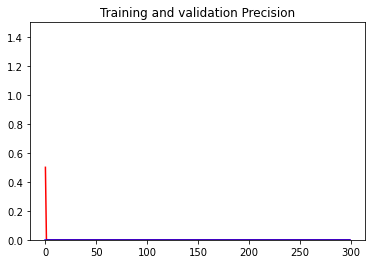

<Figure size 432x288 with 0 Axes>

In [96]:

precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [97]:
modela_glove_next_rate.evaluate(test_padded, test_labels_final)

3/3 [==============================] - 0s 13ms/step - loss: 0.3638 - precision: 0.0000e+00


[0.36378490924835205, 0.0]

### Model B, GloVE 200

In [98]:
modelb_glove200 = tf.keras.Sequential([
    tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length = max_length, trainable=False),  
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [99]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
modelb_glove200.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.Precision()])

In [100]:
modelb_glove200.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 200)         1000400   
                                                                 
 conv1d (Conv1D)             (None, 1196, 128)         128128    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,129,309
Trainable params: 128,909
Non-trainable params: 1,000,400
________________________________________

In [101]:
num_epochs = 300
history = modelb_glove200.fit(padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(val_padded, val_labels_final))

Epoch 1/300
9/9 [==============================] - 2s 158ms/step - loss: 0.5896 - precision: 0.0000e+00 - val_loss: 0.5188 - val_precision: 0.0000e+00
Epoch 2/300
9/9 [==============================] - 1s 141ms/step - loss: 0.4398 - precision: 0.0000e+00 - val_loss: 0.4280 - val_precision: 0.0000e+00
Epoch 3/300
9/9 [==============================] - 1s 155ms/step - loss: 0.3700 - precision: 0.0000e+00 - val_loss: 0.3857 - val_precision: 0.0000e+00
Epoch 4/300
9/9 [==============================] - 1s 149ms/step - loss: 0.3403 - precision: 0.0000e+00 - val_loss: 0.3672 - val_precision: 0.0000e+00
Epoch 5/300
9/9 [==============================] - 1s 149ms/step - loss: 0.3344 - precision: 0.0000e+00 - val_loss: 0.3588 - val_precision: 0.0000e+00
Epoch 6/300
9/9 [==============================] - 1s 128ms/step - loss: 0.3291 - precision: 0.0000e+00 - val_loss: 0.3537 - val_precision: 0.0000e+00
Epoch 7/300
9/9 [==============================] - 1s 148ms/step - loss: 0.3244 - precision: 0

<Figure size 432x288 with 0 Axes>

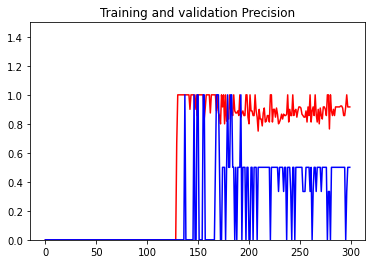

<Figure size 432x288 with 0 Axes>

In [102]:
precision = history.history['precision']
val_precision = history.history['val_precision']
epochs=range(len(precision))
plt.plot(epochs, precision, 'r')
plt.plot(epochs, val_precision, 'b')
plt.title('Training and validation Precision')
plt.ylim((0,1.5))
plt.figure()

In [103]:
modelb_glove200.evaluate(test_padded, test_labels_final)

3/3 [==============================] - 0s 42ms/step - loss: 0.4865 - precision: 0.7500


[0.48645058274269104, 0.75]